# Automatic Numper Plate Recognition

We are going to use YOLOv5 for object detection. So, here we clone the ultralytics yolo5 repo and setup the environment.

*I'm going to use Google colab wit GPU to perform the training*

In [1]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 10327, done.
remote: Total 10327 (delta 0), reused 0 (delta 0), pack-reused 10327
Receiving objects: 100% (10327/10327), 10.57 MiB | 22.78 MiB/s, done.
Resolving deltas: 100% (7130/7130), done.
     |████████████████████████████████| 596 kB 5.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Import all required modules.

In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


Download the APNR dataset provided in the assesment from google drive and extract tarball.

In [5]:
!gdown --id 11uZ5Y0i5SMvjdj3Un5mScDY-7lZeTuYp
!tar -xf ANPR_Assignment.tar.gz

Downloading...
From: https://drive.google.com/uc?id=11uZ5Y0i5SMvjdj3Un5mScDY-7lZeTuYp
To: /content/ANPR_Assignment.tar.gz
100% 23.0M/23.0M [00:00<00:00, 73.2MB/s]


The provided dataset is in VOC format. To use this data with YOLO we have to convert it in YOLO format. The difference between the two is the annotations file. \
\
In **VOC Format**, the annotations are saved as an XML file where the bounding boxes are described by using (xmin,ymin) and (xmax,ymax) points, i.e. the bottom left corner and the top right corner.\
However, In **YOLO Format**, the annotations(labels) are saved as a TXT file where the bounding boxes are decribed by (centerX,centerY), i.e. the coordinates of the center point(scaled by image size) and the width and height of the bbox.

Here, we parse the xml file and read the 'bndbox' parameter along with filename and image size and return it.

In [7]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

Test it for `car_2.xml`

In [10]:
print(extract_info_from_xml('VOC2007/Annotations/car_2.xml'))

{'bboxes': [{'class': 'license_plate', 'xmin': 40, 'ymin': 218, 'xmax': 115, 'ymax': 259}], 'filename': 'car_2.jpeg', 'image_size': (500, 314, 3)}


Define the function to convert the annotation format of our data.

In [14]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"license_plate": 0}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, _ = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("VOC2007/Annotations", info_dict["filename"].replace("jpeg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

Convert each annotation file from VOC XML format to YOLO TXT format

In [15]:
# Get the annotations
annotations = [os.path.join('VOC2007/Annotations', x) for x in os.listdir('VOC2007/Annotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('VOC2007/Annotations', x) for x in os.listdir('VOC2007/Annotations') if x[-3:] == "txt"]

100%|██████████| 669/669 [00:00<00:00, 4690.86it/s]


Try plotting a few examples to see if the conversion was done correctly

In [ ]:
random.seed(420)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
print(class_id_to_name_mapping)

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline=(255,0,0))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))],fill=(255,0,0))
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("Annotations", "JPEGImages").replace("txt", "jpg")
print(image_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)


The Conversion was correct. Now We split the trainval set to trainset and valset. And load trainset, valset and testset

In [18]:
with open('VOC2007/ImageSets/Main/trainval.txt', 'r') as file:
    train_list = file.read().split("\n")[:-1]
train_list, val_list = train_test_split(train_list, test_size = 0.2, random_state = 1)
with open('VOC2007/ImageSets/Main/test.txt', 'r') as file:
    test_list = file.read().split("\n")[:-1]

Convert names of files in the newly splitted dataset to file names corresponding to train, val, test images and annotations

In [22]:
train_images = [os.path.join('VOC2007/JPEGImages', x+'.jpg') for x in train_list]
train_annotations = [os.path.join('VOC2007/Annotations', x+".txt") for x in train_list]
val_images = [os.path.join('VOC2007/JPEGImages', x+'.jpg') for x in val_list]
val_annotations = [os.path.join('VOC2007/Annotations', x+".txt") for x in val_list]
test_images = [os.path.join('VOC2007/JPEGImages', x+'.jpg') for x in test_list]
test_annotations = [os.path.join('VOC2007/Annotations', x+".txt") for x in test_list]

Now, we move the images from VOC to YOLO folder so that yolo's train.py can find the images easily while training.

In [23]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
!mkdir -p YOLO5/images/train YOLO5/images/val YOLO5/images/test YOLO5/annotations/train YOLO5/annotations/val YOLO5/annotations/test
move_files_to_folder(train_images, 'YOLO5/images/train')
move_files_to_folder(val_images, 'YOLO5/images/val/')
move_files_to_folder(test_images, 'YOLO5/images/test/')
move_files_to_folder(train_annotations, 'YOLO5/annotations/train/')
move_files_to_folder(val_annotations, 'YOLO5/annotations/val/')
move_files_to_folder(test_annotations, 'YOLO5/annotations/test/')

Also rename annotations as labels for YOLO to work properly. And cd into yolo folder.

In [27]:
%mv YOLO5/annotations YOLO5/labels
%cd ./yolov5 

/content
/content/yolov5


Create a new `data.yaml` file to describe the custom dataset we just prepared form the given VOC dataset

In [41]:
with open('data.yaml', 'w+') as f:
    f.write('path: ../YOLO5\n')
    f.write('train: images/train/\n')
    f.write('val: images/val/\n')
    f.write('test: images/test/\n')
    f.write('\nnc: 1\n')
    f.write('\nnames: ["license_plate"]\n')

Check that yaml file is correct. Move it to `data` directory for yolo.py to find it.

In [42]:
!cat data.yaml
!mv data.yaml data/data.yaml

path: ../YOLO5
train: images/train/
val: images/val/
test: images/test/

nc: 1

names: ["license_plate"]


We'll use weights and biases to see our training progress.

In [33]:
# Setup wandb
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 140 kB 46.7 MB/s 
     |████████████████████████████████| 180 kB 51.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=f6fe9c97755a4d6044fd7af403f2ca0f3189fca1e30290e91a63c36df585492a
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=bb5e7da44883a8be58d20f7a7f3b0896a57a72b80edc9574c96309160c771489
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [35]:
!wandb login

wandb: Currently logged in as: shivanshutyagi (use `wandb login --relogin` to force relogin)


Finally train a YOLO model, choosing yolov5s (yolo small) model, as we only have 1 class to detect. We provide hyper parameters defined in `hyp.scratch.yaml` file. We choose batch size as 32 for training. We train for 100 epochs on GPU(Tesla K80). 

In [62]:
!python3 train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data data.yaml --device 0 --name YOLO_ANPR_640_100EPS

wandb: Currently logged in as: shivanshutyagi (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=YOLO_ANPR_640_100EPS, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
Resuming training from ./runs/train/YOLO_ANPR_640_100EPS/weights/last.pt
YOLOv5 🚀 v6.0-156-g95c7bc2 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, wei

Now, we'll use the best weights stored by YOLO for inference. We'll run `detect.py`, to detect licence plates on the provided test images.

In [67]:
!python3 detect.py --source ../YOLO5/images/test/ --weights runs/train/YOLO_ANPR_640_100EPS/weights/best.pt --conf 0.3 --device cpu --name YOLO_ANPR_640_100EPS_det

detect: weights=['runs/train/YOLO_ANPR_640_100EPS/weights/best.pt'], source=../YOLO5/images/test/, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=cpu, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=YOLO_ANPR_640_100EPS_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-156-g95c7bc2 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/169 /content/YOLO5/images/test/car_100.jpg: 480x640 1 license_plate, Done. (0.270s)
image 2/169 /content/YOLO5/images/test/car_104.jpg: 320x640 Done. (0.183s)
image 3/169 /content/YOLO5/images/test/car_108.jpg: 416x640 1 license_plate, Done. (0.234s)
image 4/169 /content/YOLO5/images/test/car_120.jpg: 384x640 1 license_plate, Done. (0.222s)
image 5/169 /content/YOLO5/im

Plot one random image from the testset inferenced images

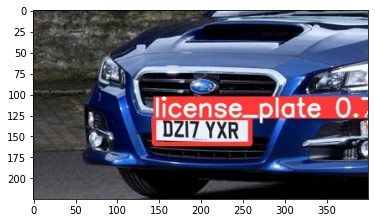

In [53]:
detections_dir = "runs/detect/YOLO_ANPR_640_100EPS_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

Also, find the mAP for the test split.

In [66]:
!python val.py --weights runs/train/YOLO_ANPR_640_100EPS/weights/best.pt --device cpu --data data.yaml --task test --name yolo_det

val: data=/content/yolov5/data/data.yaml, weights=['runs/train/YOLO_ANPR_640_100EPS/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=cpu, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.0-156-g95c7bc2 torch 1.10.0+cu111 CPU

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning '../YOLO5/labels/test.cache' images and labels... 169 found, 0 missing, 0 empty, 0 corrupted: 100% 169/169 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 6/6 [00:57<00:00,  9.58s/it]
                 all        169        183      0.886      0.847      0.884      0.469
Speed: 5.1ms pre-process, 327.3ms inference, 0.8ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/yolo_det2

We get an mAP of 0.884. which is >0.7. 🎉🎉